In [322]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import fibsem
from fibsem.imaging import masks
from fibsem.imaging import utils   
from autoscript_sdb_microscope_client.structures import AdornedImage
from PIL import Image
import logging

import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from skimage import data
from skimage import filters
from skimage.color import rgb2gray

import imageio
import cv2
import glob
import itertools
import pandas as pd

In [230]:
def xcorr(img1: np.ndarray, img2: np.ndarray, use_mask: bool = True, use_threshold: bool = True ) -> np.ndarray:

    # plt.imshow(img1.data, cmap='gray')
    # plt.show()
    # plt.imshow(img2.data, cmap='gray')
    # plt.show()

    if img1.data.shape != img2.data.shape:
        err = f"Image 1 {img1.data.shape} and Image 2 {img2.data.shape} need to have the same shape"
        logging.error(err)
        raise ValueError(err)


    if use_mask:
        # Create Fourier Transform WITH Bandpass Filter
        pixelsize_img1 = img1.data.shape
        pixelsize_img2 = img2.data.shape
        img1_mask = masks.create_bandpass_mask(pixelsize_img1, 100, 4, 3)
        img2_mask = masks.create_bandpass_mask(pixelsize_img2, 100, 4, 3)
        img1fft = np.fft.ifftshift(img1_mask * np.fft.fftshift(np.fft.fft2(img1.data)))
        img2fft = np.fft.ifftshift(img2_mask * np.fft.fftshift(np.fft.fft2(img2.data)))
        assert img1_mask is not None, "Mask1 can not be None when using a Mask"
        assert img2_mask is not None, "Mask2 can not be None when using a Mask"
    
       
       
    else:
        # Create Fourier Transform
        img1fft = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(img1.data)))
        img2fft = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(img2.data)))

    # Do some shady normalization(?)
    n_pixels1 = img1.data.shape[0] * img1.data.shape[1]
    img1fft[0, 0] = 0
    tmp = img1fft * np. conj(img1fft)
    img1fft = n_pixels1 * img1fft / np.sqrt(tmp.sum())
    

    n_pixels2 = img2.data.shape[0] * img2.data.shape[1]
    img2fft[0, 0] = 0
    tmp = img2fft * np. conj(img2fft)
    img2fft = n_pixels2 * img2fft / np.sqrt(tmp.sum())


    if use_threshold:
        #Create threshold (Otsu's method) in abs Space
        abs1 = np.fft.fftshift(np.fft.ifftshift(np.fft.ifft2(img1fft)))
        abs2 = np.fft.fftshift(np.fft.ifftshift(np.fft.ifft2(img2fft)))
        otsu1 = filters.threshold_otsu(np.abs(abs1))
        otsu2 = filters.threshold_otsu(np.abs(abs2))

         #Create segmented binary Img
        binary1 = (abs1 > otsu1)*1
        # plt.title("Threshold: >"+str(otsu1))
        # plt.imshow(binary1, cmap='gray')
        # plt.show()
        binary2 = (abs2 > otsu2)*1
        # plt.title("Threshold: >"+str(otsu2))
        # plt.imshow(binary2, cmap='gray')
        # plt.show()

        #Back to Fourier Space for cross-correlation
        fft1 = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(binary1)))
        fft2 = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(binary2)))

        # Cross-correlate the two images
        corr = np.real(np.fft.fftshift(np.fft.ifft2(fft1 * np.conj(fft2))))
        # plt.imshow(corr)
        # plt.show()

        #Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        # print('Center:', cen, 'Error:', err)
        return corr, valMax, cen, err,
        

    else:
        # Cross-correlate the two images
        corr = np.real(np.fft.fftshift(np.fft.ifft2(img1fft * np.conj(img2fft))))
        # plt.imshow(corr)
        # plt.show()

        #Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        # AmaxX, AmaxY = np.unravel_index(np.argmax(Acorr), Acorr.shape)
        # Acen = np.asarray(Acorr.shape) / 2
        # Aerr = np.array(Acen - [AmaxX, AmaxY], int)
        # AvalMax = np.amax(Acorr)
        # print('Center:', cen, 'Error:', err)
        return corr, valMax, cen, err
        



In [249]:
data = []
files = glob.glob("../xcorrtest/*tif")
for file in files:
    img = mpimg.imread(file)
    image = AdornedImage(img, None)
    data.append(image)
arr = np.array(data)

# AdornedImage(np.roll(arr1[i].data, shift=(100,100), axis=(0,1)))

arr1 = arr[0: arr.size: 2]
arr2 = arr[1: arr.size: 2]

# errs = []
# corrs = []
# for i in range(5):
#     corr1, maxVal1, cen1, err1 = xcorr(arr1[i], arr2[i], False, False)
#     corr2, maxVal2, cen2, err2 = xcorr(arr1[i], arr2[i], True, False)
#     corr3, maxVal3, cen3, err3 = xcorr(arr1[i], arr2[i], False, True)
#     corr4, maxVal4, cen4, err4 = xcorr(arr1[i], arr2[i], True, True)
#     errs.append([err1, err2, err3, err4])
#     corrs.append([corr1, corr2, corr3, corr4])


dict_list = []

for i in range(5):
    for use_mask in [True, False]:
        for use_threshold in [True, False]:
            corr, maxVal, cen, err = xcorr(arr1[i], arr2[i], use_mask, use_threshold)
            data_dict = {"n":i, "use_mask":use_mask, "use_threshold":use_threshold,
            "corr":corr, "maxVal":maxVal, "cen":cen, "err_x":err[0], "err_y":err[1]}
            dict_list.append(data_dict)

from pprint import pprint




In [244]:
df = pd.DataFrame.from_dict(dict_list)
display(df)

,n,use_mask,use_threshold,corr,maxVal,cen,err_x,err_y
0,0,True,True,"[[10700.0, 10688.0, 10689.0, 10715.0, 10805.0,...",19839.000000,"[512.0, 768.0]",-89,-475
1,0,True,False,"[[-17276.23155174614, -14666.961208302531, -11...",109706.713243,"[512.0, 768.0]",63,-460
2,0,False,True,"[[31501.0, 31500.0, 31546.0, 31536.0, 31646.0,...",44862.000000,"[512.0, 768.0]",229,425
3,0,False,False,"[[26759.695411794884, 26632.276854104886, 2668...",273276.411388,"[512.0, 768.0]",47,-458
4,1,True,True,"[[3821.0, 3906.0, 4006.0, 4114.0, 4221.0, 4339...",9249.000000,"[512.0, 768.0]",-5,-10
5,1,True,False,"[[-49753.01689624578, -48049.06189529236, -460...",121278.263874,"[512.0, 768.0]",-3,-10
6,1,False,True,"[[39703.0, 39621.0, 39568.0, 39572.0, 39441.0,...",41064.000000,"[512.0, 768.0]",409,-745
7,1,False,False,"[[55881.04782960403, 55689.615463648675, 56496...",78288.963590,"[512.0, 768.0]",-12,-649
8,2,True,True,"[[14235.0, 14113.0, 13988.0, 13876.0, 13790.0,...",23265.000000,"[512.0, 768.0]",124,0
9,2,True,False,"[[-5626.5663873188405, -7200.271669025693, -85...",124519.500526,"[512.0, 768.0]",63,1


In [264]:
df_filter = df[(df["use_mask"]==True) & (df["use_threshold"]==True)]
df.sort_values(by=["err_x", "err_y"])
display(df_filter)



,n,use_mask,use_threshold,corr,maxVal,cen,err_x,err_y,err_mag
0,0,True,True,"[[10700.0, 10688.0, 10689.0, 10715.0, 10805.0,...",19839.0,"[512.0, 768.0]",-89,-475,42275
4,1,True,True,"[[3821.0, 3906.0, 4006.0, 4114.0, 4221.0, 4339...",9249.0,"[512.0, 768.0]",-5,-10,50
8,2,True,True,"[[14235.0, 14113.0, 13988.0, 13876.0, 13790.0,...",23265.0,"[512.0, 768.0]",124,0,0
12,3,True,True,"[[1943.0000000000002, 1949.0, 1961.00000000000...",16726.0,"[512.0, 768.0]",21,-10,-210
16,4,True,True,"[[4307.0, 4294.0, 4299.0, 4339.0, 4387.0, 4449...",11491.0,"[512.0, 768.0]",-36,-4,144


In [270]:
df_n = df[(df["n"]==0)]
df.sort_values(by=["err_x", "err_y"])
display(df_n)

,n,use_mask,use_threshold,corr,maxVal,cen,err_x,err_y,err_mag
0,0,True,True,"[[10700.0, 10688.0, 10689.0, 10715.0, 10805.0,...",19839.000000,"[512.0, 768.0]",-89,-475,42275
1,0,True,False,"[[-17276.23155174614, -14666.961208302531, -11...",109706.713243,"[512.0, 768.0]",63,-460,-28980
2,0,False,True,"[[31501.0, 31500.0, 31546.0, 31536.0, 31646.0,...",44862.000000,"[512.0, 768.0]",229,425,97325
3,0,False,False,"[[26759.695411794884, 26632.276854104886, 2668...",273276.411388,"[512.0, 768.0]",47,-458,-21526


In [275]:
for i in range(5):
    all = df[df["n"]==i]
    display(all)


,n,use_mask,use_threshold,corr,maxVal,cen,err_x,err_y,err_mag
0,0,True,True,"[[10700.0, 10688.0, 10689.0, 10715.0, 10805.0,...",19839.000000,"[512.0, 768.0]",-89,-475,42275
1,0,True,False,"[[-17276.23155174614, -14666.961208302531, -11...",109706.713243,"[512.0, 768.0]",63,-460,-28980
2,0,False,True,"[[31501.0, 31500.0, 31546.0, 31536.0, 31646.0,...",44862.000000,"[512.0, 768.0]",229,425,97325
3,0,False,False,"[[26759.695411794884, 26632.276854104886, 2668...",273276.411388,"[512.0, 768.0]",47,-458,-21526


,n,use_mask,use_threshold,corr,maxVal,cen,err_x,err_y,err_mag
4,1,True,True,"[[3821.0, 3906.0, 4006.0, 4114.0, 4221.0, 4339...",9249.000000,"[512.0, 768.0]",-5,-10,50
5,1,True,False,"[[-49753.01689624578, -48049.06189529236, -460...",121278.263874,"[512.0, 768.0]",-3,-10,30
6,1,False,True,"[[39703.0, 39621.0, 39568.0, 39572.0, 39441.0,...",41064.000000,"[512.0, 768.0]",409,-745,-304705
7,1,False,False,"[[55881.04782960403, 55689.615463648675, 56496...",78288.963590,"[512.0, 768.0]",-12,-649,7788


,n,use_mask,use_threshold,corr,maxVal,cen,err_x,err_y,err_mag
8,2,True,True,"[[14235.0, 14113.0, 13988.0, 13876.0, 13790.0,...",23265.000000,"[512.0, 768.0]",124,0,0
9,2,True,False,"[[-5626.5663873188405, -7200.271669025693, -85...",124519.500526,"[512.0, 768.0]",63,1,63
10,2,False,True,"[[40870.0, 41053.0, 40782.0, 41033.0, 41133.0,...",52206.000000,"[512.0, 768.0]",28,2,56
11,2,False,False,"[[-22137.670884437153, -23393.78358286966, -23...",152745.614862,"[512.0, 768.0]",7,21,147


,n,use_mask,use_threshold,corr,maxVal,cen,err_x,err_y,err_mag
12,3,True,True,"[[1943.0000000000002, 1949.0, 1961.00000000000...",16726.000000,"[512.0, 768.0]",21,-10,-210
13,3,True,False,"[[-13483.728146024769, -12463.639646481453, -1...",211145.993499,"[512.0, 768.0]",76,-6,-456
14,3,False,True,"[[46867.0, 46699.0, 46835.0, 46705.0, 46788.0,...",83572.000000,"[512.0, 768.0]",10,203,2030
15,3,False,False,"[[134011.14609926517, 134108.52023136622, 1343...",258870.566503,"[512.0, 768.0]",-476,98,-46648


,n,use_mask,use_threshold,corr,maxVal,cen,err_x,err_y,err_mag
16,4,True,True,"[[4307.0, 4294.0, 4299.0, 4339.0, 4387.0, 4449...",11491.000000,"[512.0, 768.0]",-36,-4,144
17,4,True,False,"[[-15024.453126266711, -15258.839133214286, -1...",157283.942238,"[512.0, 768.0]",9,-3,-27
18,4,False,True,"[[36653.0, 36421.0, 36475.0, 36466.0, 36714.0,...",66170.000000,"[512.0, 768.0]",-55,511,-28105
19,4,False,False,"[[-1604.3137580050752, -785.8720882756534, -66...",188379.991432,"[512.0, 768.0]",122,541,66002


In [360]:
from dataclasses import dataclass
@dataclass
class Point:
    x: float = 0.0
    y: float = 0.0
def strech(img1: np.ndarray, tilt_degree: float):
    img1 = mpimg.imread("../xcorrtest/jcut_lowres_ib.tif")
    img1 = AdornedImage(img1, None)
    tilt = np.deg2rad(10)
    shape = int(img1.data.shape[0] / np.cos(tilt)), int(img.data.shape[1] / np.cos(tilt))
    resized = np.asarray(Image.fromarray(img1.data))
    c = Point(resized.shape[1]//2, resized.shape[0]//2)
    dy, dx = img1.data.shape[0]//2, img1.data.shape[1]//2
    scaled_img = resized[c.y-dy:c.y+dy, c.x-dx:c.x+dx]
    new_img = AdornedImage(data=scaled_img)
    return new_img




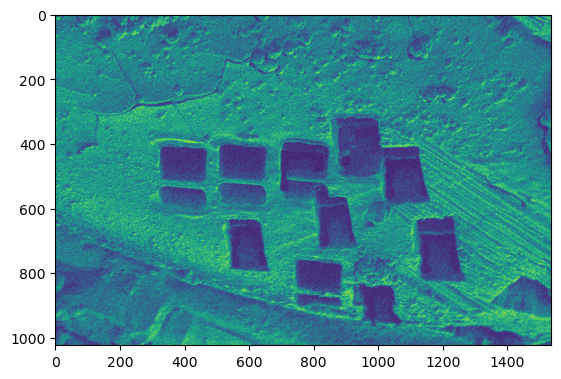